# Read in the data

In [71]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [72]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [73]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [74]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [75]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [76]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [77]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [78]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [79]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [80]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

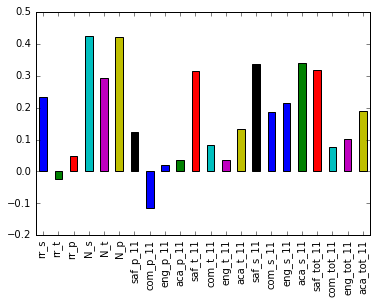

In [81]:
%matplotlib inline
import matplotlib.pyplot as plt
survey_cor=correlations[survey_fields]
survey_cor.plot.bar()


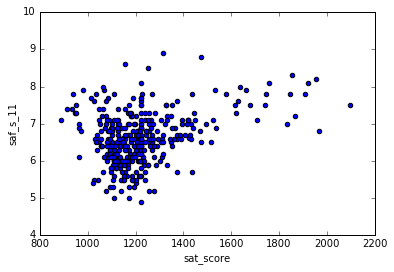

In [82]:
combined.plot.scatter(x="sat_score",y="saf_s_11")

In [83]:
safety=combined.groupby("school_dist").agg(numpy.mean)

In [84]:
cols=[c for c in combined.columns if c.startswith("saf_")]
cols

['saf_p_11', 'saf_t_11', 'saf_s_11', 'saf_tot_11']

In [85]:
safety[cols]

,saf_p_11,saf_t_11,saf_s_11,saf_tot_11
school_dist,,,,
01,8.233333,7.066667,6.768611,7.433333
02,8.254167,7.404167,6.910660,7.520833
03,8.316667,6.675000,6.716667,7.233333
04,8.385714,7.871429,6.885714,7.714286
05,8.085714,6.857143,6.314286,7.085714
06,8.530000,7.490000,6.950000,7.660000
07,8.423077,6.969231,6.800000,7.392308
08,8.172727,7.109091,6.364697,7.218182
09,8.510000,6.935000,6.655000,7.365000


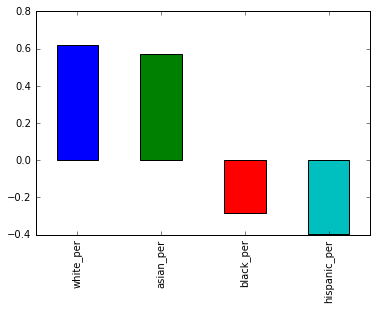

In [86]:
races=["white_per","asian_per","black_per","hispanic_per"]
race_cor=correlations[races]
race_cor.plot.bar()

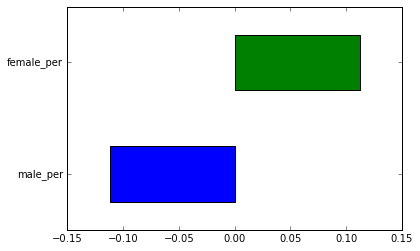

In [87]:
gender_cor=correlations[["male_per","female_per"]]
gender_cor.plot.barh()

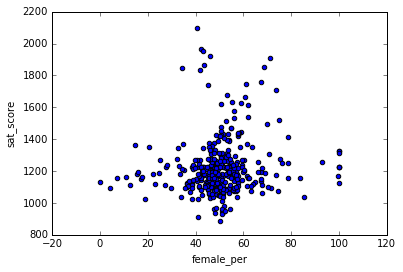

In [88]:
combined.plot.scatter(x="female_per",y="sat_score")

In [89]:
fem=combined[combined["female_per"]>60]
fem

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.000000,604.000000,628.000000,1856.000000,0,129.028846,197.038462,...,0,0,0,0,0,0,"525 East Houston Street\nNew York, NY 10002\n(...",40.718962,-73.976066,01
9,02M296,HIGH SCHOOL OF HOSPITALITY MANAGEMENT,58,374.000000,375.000000,362.000000,1111.000000,High School of Hospitality Management,129.028846,197.038462,...,0,0,0,0,0,0,"525 West 50Th Street\nNew York, NY 10019\n(40....",40.765027,-73.992517,02
14,02M308,LOWER MANHATTAN ARTS ACADEMY,40,403.000000,392.000000,405.000000,1200.000000,Lower Manhattan Arts Academy,129.028846,197.038462,...,Then to Manhattan students or residents,Then to New York City residents,0,0,0,0,"350 Grand Street\nNew York, NY 10002\n(40.7168...",40.716867,-73.989532,02
15,02M316,URBAN ASSEMBLY SCHOOL OF BUSINESS FOR YOUNG WO...,42,373.000000,370.000000,384.000000,1127.000000,0,129.028846,197.038462,...,Then to New York City residents,0,0,0,0,0,"26 Broadway\nNew York, NY 10004\n(40.705234939...",40.705235,-74.013315,02
16,02M374,GRAMERCY ARTS HIGH SCHOOL,60,391.000000,391.000000,394.000000,1176.000000,0,129.028846,197.038462,...,0,0,0,0,0,0,"40 Irving Place\nNew York, NY 10003\n(40.73551...",40.735519,-73.987604,02
22,02M408,PROFESSIONAL PERFORMING ARTS HIGH SCHOOL,94,509.000000,490.000000,523.000000,1522.000000,PROFESSIONAL PERFORMING ARTS,20.000000,20.000000,...,0,0,0,0,0,0,"328 West 48 Street\nNew York, NY 10036\n(40.76...",40.761433,-73.988024,02
26,02M416,ELEANOR ROOSEVELT HIGH SCHOOL,127,572.000000,594.000000,592.000000,1758.000000,Eleanor Roosevelt High School,155.000000,235.000000,...,0,0,0,0,0,0,"411 East 76 Street\nNew York, NY 10021\n(40.77...",40.770116,-73.953379,02
27,02M418,MILLENNIUM HIGH SCHOOL,144,528.000000,553.000000,533.000000,1614.000000,Millennium High School,86.000000,95.000000,...,0,0,0,0,0,0,"75 Broad Street\nNew York, NY 10004\n(40.70492...",40.704920,-74.011514,02
29,02M420,HIGH SCHOOL FOR HEALTH PROFESSIONS AND HUMAN S...,336,429.000000,449.000000,428.000000,1306.000000,HEALTH PROF & HUMAN SVCS,204.000000,248.000000,...,0,0,0,0,0,0,"345 East 15Th Street\nNew York, NY 10003\n(40....",40.732485,-73.983053,02
34,02M439,MANHATTAN VILLAGE ACADEMY,95,441.000000,473.000000,458.000000,1372.000000,MANHATTAN VILLAGE ACADEMY HS,42.000000,69.000000,...,0,0,0,0,0,0,"43 West 22 Street\nNew York, NY 10010\n(40.741...",40.741495,-73.991445,02


In [90]:
fem=fem[fem['sat_score']>1700]
fem

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.0,604.0,628.0,1856.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"525 East Houston Street\nNew York, NY 10002\n(...",40.718962,-73.976066,01
26,02M416,ELEANOR ROOSEVELT HIGH SCHOOL,127,572.0,594.0,592.0,1758.0,Eleanor Roosevelt High School,155.000000,235.000000,...,0,0,0,0,0,0,"411 East 76 Street\nNew York, NY 10021\n(40.77...",40.770116,-73.953379,02
60,03M479,BEACON HIGH SCHOOL,261,577.0,575.0,592.0,1744.0,BEACON SCHOOL,166.000000,197.000000,...,0,0,0,0,0,0,"227-243 West 61St Street\nNew York, NY 10023\n...",40.772158,-73.987797,03
61,03M485,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,531,566.0,564.0,577.0,1707.0,FIORELLO H.LAGUARDIA HS,691.000000,1236.000000,...,0,0,0,0,0,0,"100 Amsterdam Avenue\nNew York, NY 10023\n(40....",40.773671,-73.985269,03
302,25Q525,TOWNSEND HARRIS HIGH SCHOOL,278,621.0,651.0,638.0,1910.0,TOWNSEND HARRIS HS,613.000000,796.000000,...,0,0,0,0,0,0,"149-11 Melbourne Avenue\nFlushing, NY 11367\n(...",40.734408,-73.821417,25
